In [33]:
%load_ext autoreload
%autoreload 2

import sys         
sys.path.append('./../../src/') 


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data.sleep_edf import load_data_split
from signals.eeg import EEGSignal, MultiChannelEEGSignal
from signals.utils import get_windows

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
train_data, train_labels = load_data_split('train')

sig = EEGSignal("eeg", train_data[0, 0], fs=100)
sig_1 = EEGSignal("eeg_1", train_data[0, 1], fs=100)

multi_eeg = MultiChannelEEGSignal(signals={"eeg": sig, "eeg_1": sig_1})

In [36]:
multi_eeg.get_windows(win_len_s=25, step_s=1)

{'Fpz-Cz': [<signals.eeg.EEGSignal at 0x7f0c2adde9d0>,
 'Pz-Oz': [<signals.eeg.EEGSignal at 0x7f0c2adde580>,
  <signals.eeg.EEGSignal at 0x7f0c2adde100>]}

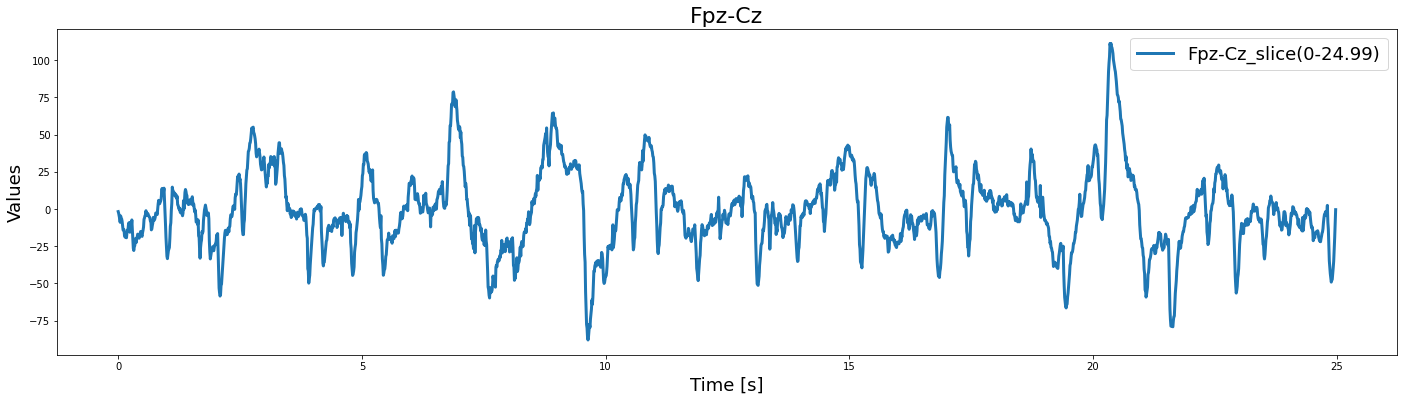

In [38]:
multi_eeg.windows['Fpz-Cz'][0].plot(0, -1)

In [39]:
multi_eeg.get_per_window_features_representation(return_arr=True).shape

(2, 6, 10)

In [42]:
multi_eeg.get_per_window_waveform_representation(return_arr=True).shape

(2, 6, 2500)

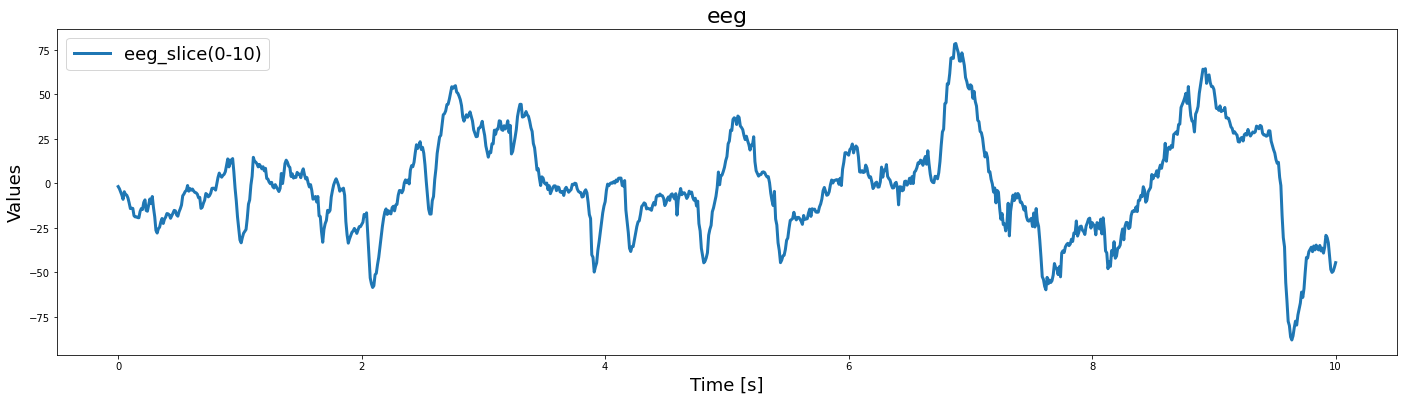

In [11]:
sig.plot()

In [142]:
feats = []
n_samples = 10000
for data, label in tqdm(zip(train_data[:n_samples], train_labels[:n_samples]), total=n_samples):
    sig_0 = EEGSignal("eeg", data[0].numpy(), fs=100)
    features_0 = sig_0.extract_features(return_arr=False)
    
    sig_1 = EEGSignal("eeg", data[1].numpy(), fs=100)
    features_1 = sig_1.extract_features(return_arr=False)
    
    features = {
        **{f"0_{k}": v for k, v in features_0.items()},
        **{f"1_{k}": v for k, v in features_1.items()},
    }
    features['target'] = label
    feats.append(features)
    
feats = pd.DataFrame(feats)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [143]:
feats

,0_whole_signal_features__basic_features__mean,0_whole_signal_features__basic_features__std,0_whole_signal_features__basic_features__median,0_whole_signal_features__basic_features__skewness,0_whole_signal_features__basic_features__kurtosis,0_whole_signal_features__rel_power_features__delta,0_whole_signal_features__rel_power_features__theta,0_whole_signal_features__rel_power_features__alpha,0_whole_signal_features__rel_power_features__sigma,0_whole_signal_features__rel_power_features__beta,...,1_whole_signal_features__basic_features__std,1_whole_signal_features__basic_features__median,1_whole_signal_features__basic_features__skewness,1_whole_signal_features__basic_features__kurtosis,1_whole_signal_features__rel_power_features__delta,1_whole_signal_features__rel_power_features__theta,1_whole_signal_features__rel_power_features__alpha,1_whole_signal_features__rel_power_features__sigma,1_whole_signal_features__rel_power_features__beta,target
0,0.162968,25.730206,-0.747253,0.326898,1.379441,0.093205,0.005404,0.000811,0.000303,0.000119,...,12.444923,0.316239,-0.097821,1.993737,0.023384,0.012620,0.014102,0.013275,0.010659,0
1,-0.463430,37.519361,0.597802,0.154747,2.268912,0.096387,0.002862,0.000379,0.000168,0.000075,...,16.251674,0.768010,-0.306522,2.312267,0.029497,0.009548,0.015110,0.014178,0.009375,0
2,0.386678,41.793593,0.647619,0.836940,2.981657,0.097550,0.001748,0.000285,0.000149,0.000088,...,10.433290,0.135531,0.330953,3.586112,0.029538,0.010235,0.015098,0.015460,0.008835,0
3,-1.057778,26.797414,0.647619,-0.337751,1.668557,0.092649,0.005715,0.000690,0.000409,0.000182,...,14.994949,-0.496947,0.401492,4.872094,0.062892,0.005858,0.007109,0.008614,0.004581,0
4,1.399687,21.049509,0.547985,-0.171361,3.188941,0.093041,0.005250,0.000853,0.000383,0.000174,...,10.127932,0.406593,-0.095630,2.093658,0.023483,0.010355,0.015922,0.014982,0.010390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.190748,12.454362,-0.544078,0.235780,0.523211,0.066253,0.011026,0.007679,0.014288,0.000619,...,9.070824,-1.197802,0.430742,0.641054,0.060211,0.017776,0.008363,0.012847,0.000669,2
9996,-0.418514,12.405635,-0.279609,-0.241175,0.948846,0.059865,0.014695,0.011829,0.013559,0.000653,...,10.965646,-0.546520,-0.213994,1.718729,0.062398,0.014805,0.013274,0.010252,0.000521,2
9997,-0.430121,16.316103,0.601954,-0.491892,1.857595,0.081972,0.007414,0.003802,0.006363,0.000327,...,13.914669,-0.360440,-0.492155,7.252648,0.079835,0.009609,0.004457,0.005852,0.000308,2
9998,-0.052548,12.873133,0.161172,-0.430934,1.274968,0.067760,0.012033,0.008442,0.010886,0.000694,...,9.340673,-0.360440,-0.006099,0.289577,0.062433,0.017282,0.011658,0.008478,0.000670,2


In [152]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from evaluation.metrics import get_classification_metrics
from evaluation.visualisations import plot_confusion_matrix, plot_feature_importance

X_train, X_test, y_train, y_test = train_test_split(feats.drop('target', axis=1), feats['target'], test_size=0.33, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

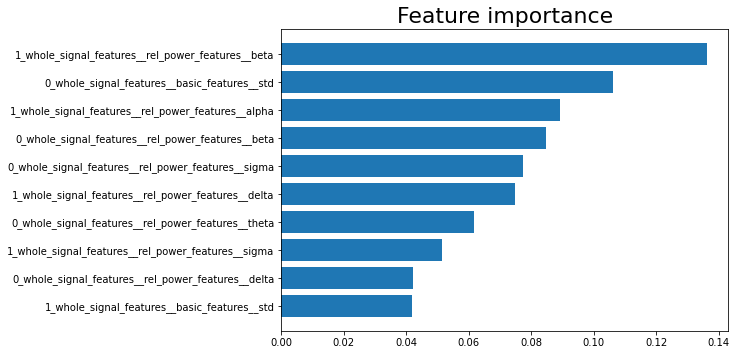

In [153]:
plot_feature_importance(X_train.columns.values, model.feature_importances_)

In [154]:
classnames = np.array([INV_EVENT_ID[l] for l in np.unique(y_pred)])

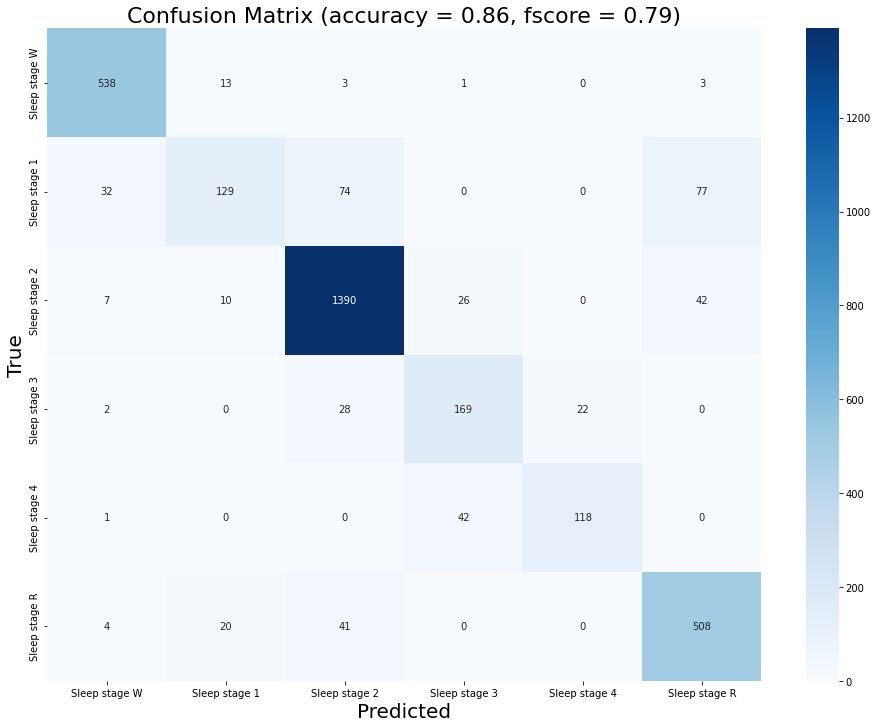

In [155]:
plot_confusion_matrix(y_test, y_pred, classnames)